# Speech Emotion Recognition Project

In [ ]:
import os
import json


kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_file = os.path.join(kaggle_dir, "kaggle.json")


os.makedirs(kaggle_dir, exist_ok=True)


api_token = {
    "username": "",  # Replace with your Kaggle username and key
    "key": ""         
}

# Write the credentials to kaggle.json
with open(kaggle_file, 'w') as file:
    json.dump(api_token, file)

print(f"kaggle.json file created at: {kaggle_file}")


kaggle.json file created at: C:\Users\dhruv/.kaggle\kaggle.json


!pip install np_utils

!pip install kaggle

!pip install librosa

!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import kaggle
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

## Downloading Datasets

In [7]:
!kaggle datasets download -d ejlok1/cremad

Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
cremad.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
surrey-audiovisual-expressed-emotion-savee.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)


### Unzip the datasets

In [10]:
import zipfile
import os

# Define the paths for the zip files
zip_files = [
    r"C:\Users\dhruv\cremad.zip",
    r"C:\Users\dhruv\ravdess-emotional-speech-audio.zip",
    r"C:\Users\dhruv\surrey-audiovisual-expressed-emotion-savee.zip"
]

# Loop through each zip file and extract its contents
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(r"C:\Users\dhruv")  # Extract to the same directory
    print(f"Extracted: {zip_file}")


Extracted: C:\Users\dhruv\cremad.zip
Extracted: C:\Users\dhruv\ravdess-emotional-speech-audio.zip
Extracted: C:\Users\dhruv\surrey-audiovisual-expressed-emotion-savee.zip


In [11]:
import zipfile

# Define the path for the zip file
zip_file_path = r"C:\Users\dhruv\toronto-emotional-speech-set-tess.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(r"C:\Users\dhruv")  # Extract to the same directory
print(f"Extracted: {zip_file_path}")


Extracted: C:\Users\dhruv\toronto-emotional-speech-set-tess.zip


### Paths for Datasets

In [13]:
# Update the paths to match your directory structure on Windows
Ravdess = r"C:\Users\dhruv\audio_speech_actors_01-24"
Crema = r"C:\Users\dhruv\AudioWAV"
Tess = r"C:\Users\dhruv\TESS Toronto emotional speech set data"
Savee = r"C:\Users\dhruv\ALL"


## 1. Ravdess DataFrame

In [15]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess +'/'+ dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1  neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
2  neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
3  neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
4     calm  C:\Users\dhruv\audio_speech_actors_01-24/Actor...

## 2. Crema DataFrame

In [17]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '\\' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                         Path
0    angry  C:\Users\dhruv\AudioWAV\1001_DFA_ANG_XX.wav
1  disgust  C:\Users\dhruv\AudioWAV\1001_DFA_DIS_XX.wav
2     fear  C:\Users\dhruv\AudioWAV\1001_DFA_FEA_XX.wav
3    happy  C:\Users\dhruv\AudioWAV\1001_DFA_HAP_XX.wav
4  neutral  C:\Users\dhruv\AudioWAV\1001_DFA_NEU_XX.wav

## 3. TESS dataset

In [19]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))  # Use os.path.join for cross-platform compatibility
    for file in directories:
        part = file.split('.')[0]
        parts = part.split('_')  # Split by underscore

        # Check if the parts list has at least 3 elements
        if len(parts) > 2:
            if parts[2] == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(parts[2])
        else:
            file_emotion.append('unknown')  # Handle cases with unexpected filename structure

        file_path.append(os.path.join(Tess, dir, file))  # Use os.path.join for file path

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head()


Emotions                                               Path
0    angry  C:\Users\dhruv\TESS Toronto emotional speech s...
1    angry  C:\Users\dhruv\TESS Toronto emotional speech s...
2    angry  C:\Users\dhruv\TESS Toronto emotional speech s...
3    angry  C:\Users\dhruv\TESS Toronto emotional speech s...
4    angry  C:\Users\dhruv\TESS Toronto emotional speech s...

## 4. CREMA-D dataset

The audio files in this dataset are named in a way such that the prefix letters describes the emotion classes as the below:

<ul>
<li> 'a' = Anger
<li> 'd' = Disgust
<li> 'f' = Fear
<li> 'h' = Happiness
<li> 'n' = Neutral
<li> 'sa' = Sadness
<li> 'su' = Surprise
</ul>

In [22]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '\\' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                           Path
0    angry  C:\Users\dhruv\ALL\DC_a01.wav
1    angry  C:\Users\dhruv\ALL\DC_a02.wav
2    angry  C:\Users\dhruv\ALL\DC_a03.wav
3    angry  C:\Users\dhruv\ALL\DC_a04.wav
4    angry  C:\Users\dhruv\ALL\DC_a05.wav

In [23]:
#creating combined dataframe
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions                                               Path
0      neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1      neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
2      neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
3      neutral  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
4         calm  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
...        ...                                                ...
1435  surprise  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1436  surprise  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1437  surprise  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1438  surprise  C:\Users\dhruv\audio_speech_actors_01-24/Actor...
1439  surprise  C:\Users\dhruv\audio_speech_actors_01-24/Actor...

[1440 rows x 2 columns]

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

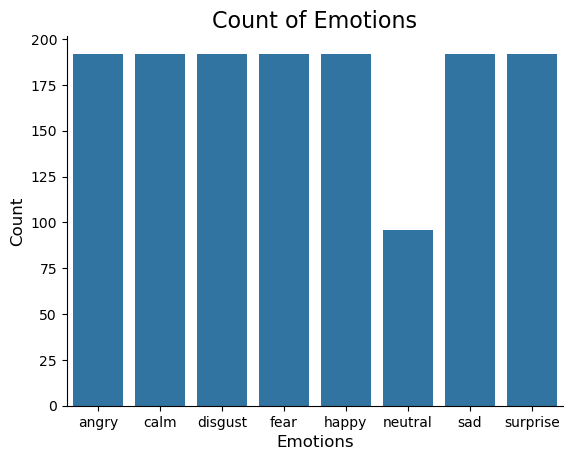

In [27]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')  # Specify x parameter
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals
<li> Waveplots - Waveplots let us know the loudness of the audio at a given time
<li> Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [29]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Wave Plots for the Emotions

## <li>Fear

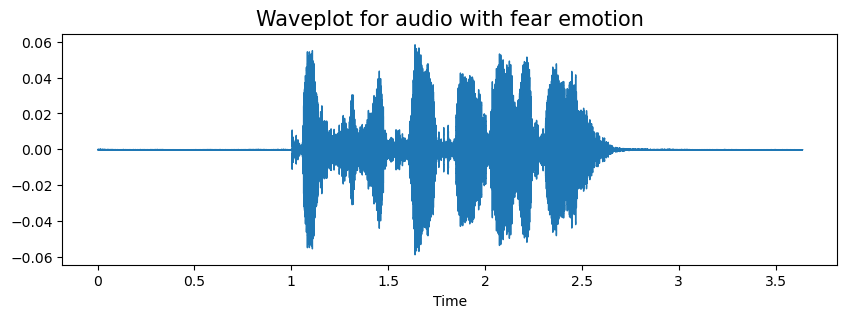

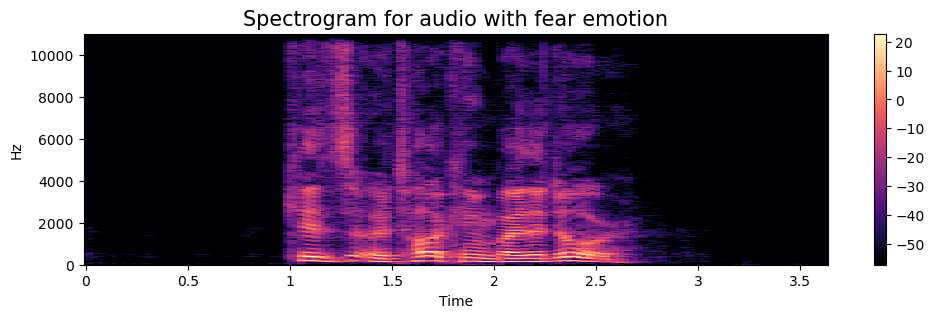

In [32]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Angry

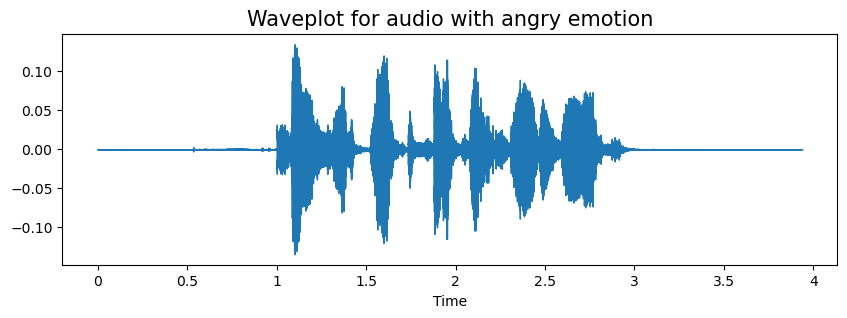

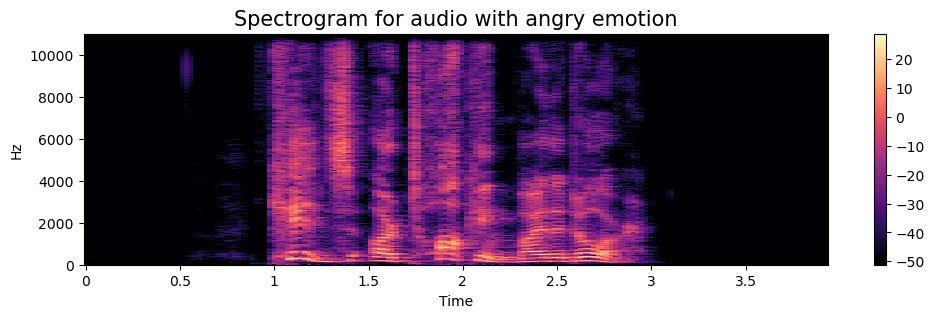

In [34]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Sad

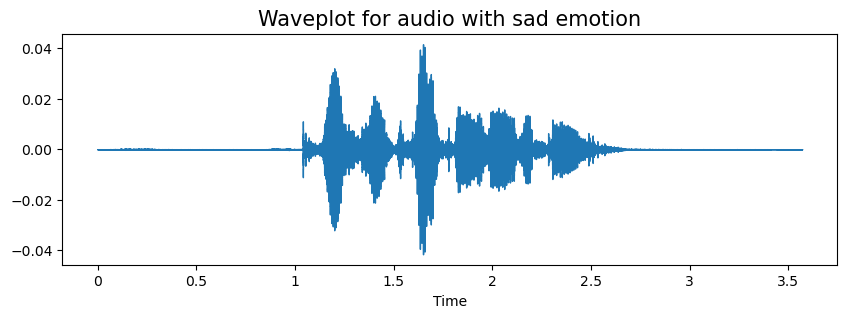

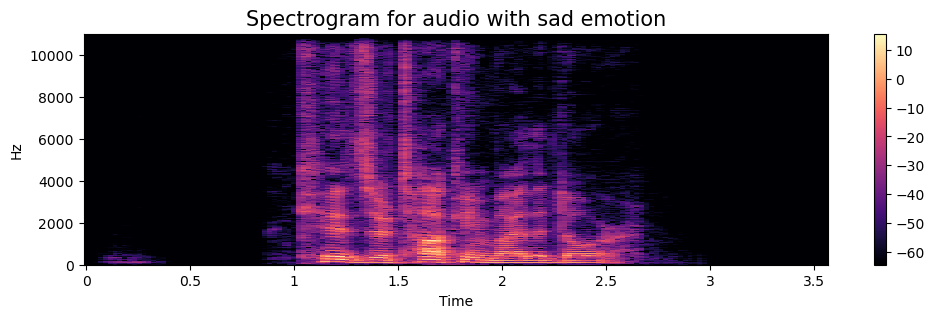

In [36]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Happy

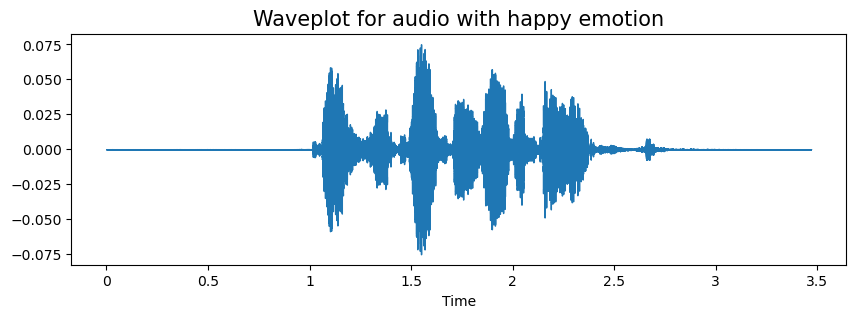

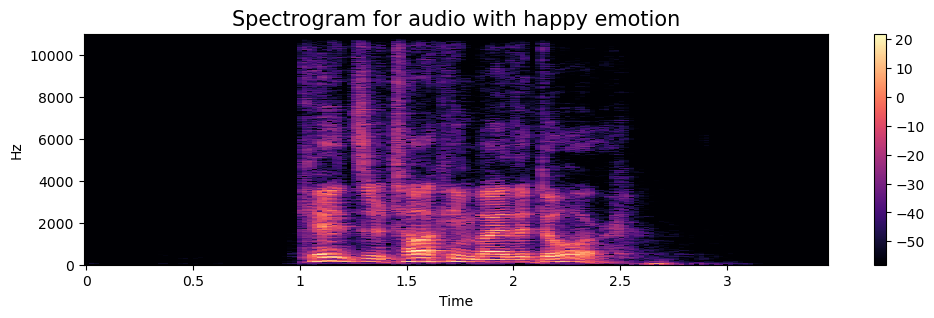

In [38]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

<li>To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
<li>The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
<li>In order to this to work adding the perturbations must conserve the same label as the original training sample.
<li>In images data augmention can be performed by shifting the image, zooming, rotating, cropping ...etc

But We need to check which augmentation techinques works better for our dataset

In [42]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

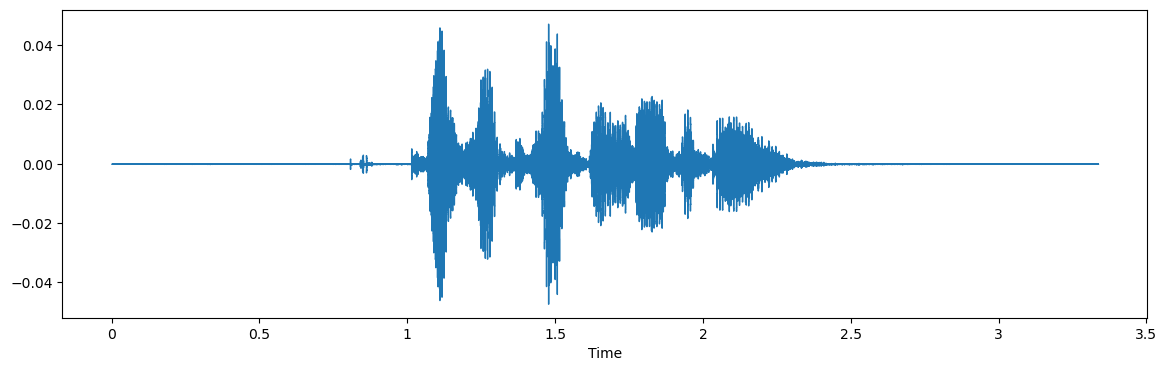

In [44]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

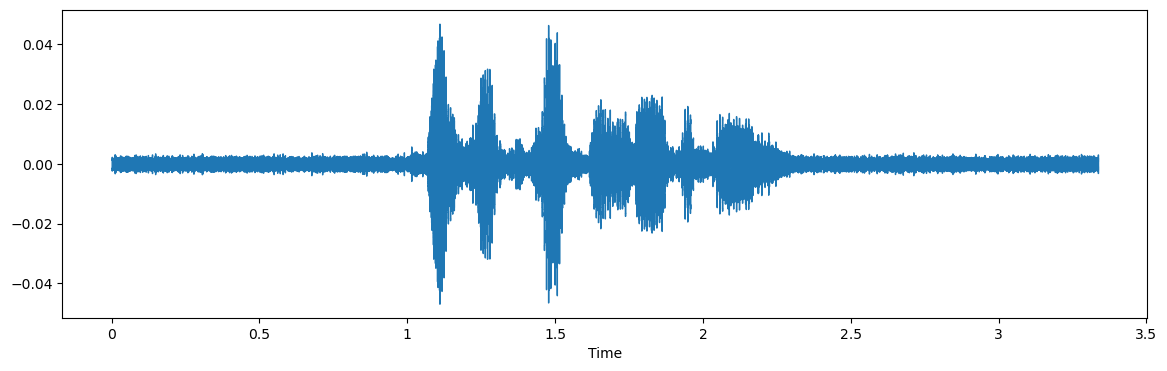

In [46]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Here, we can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3.Stretching

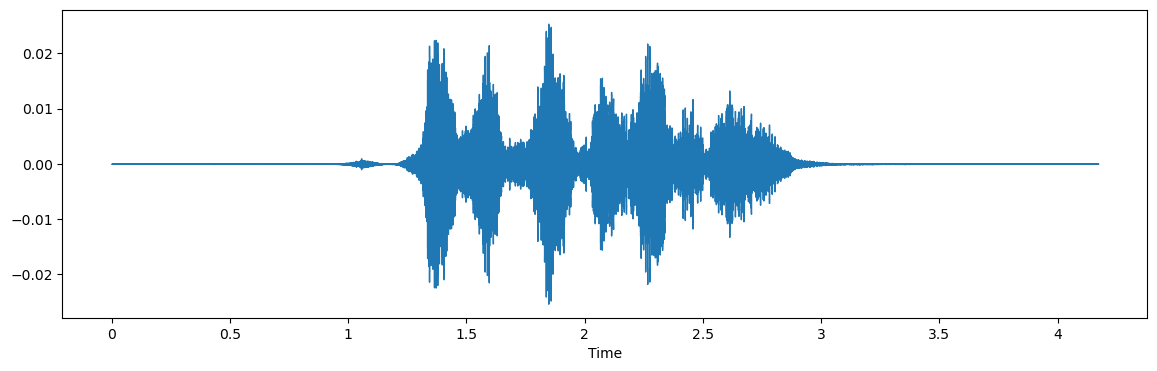

In [49]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4.Shifting

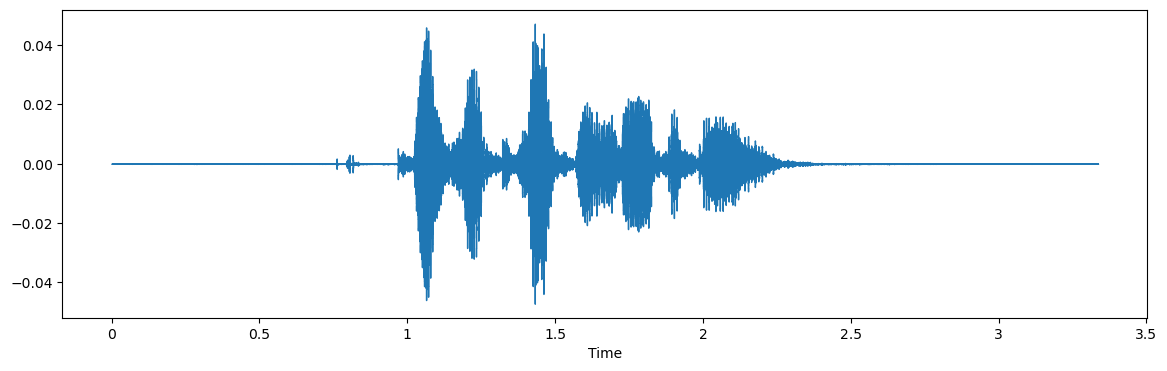

In [51]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.Pitch

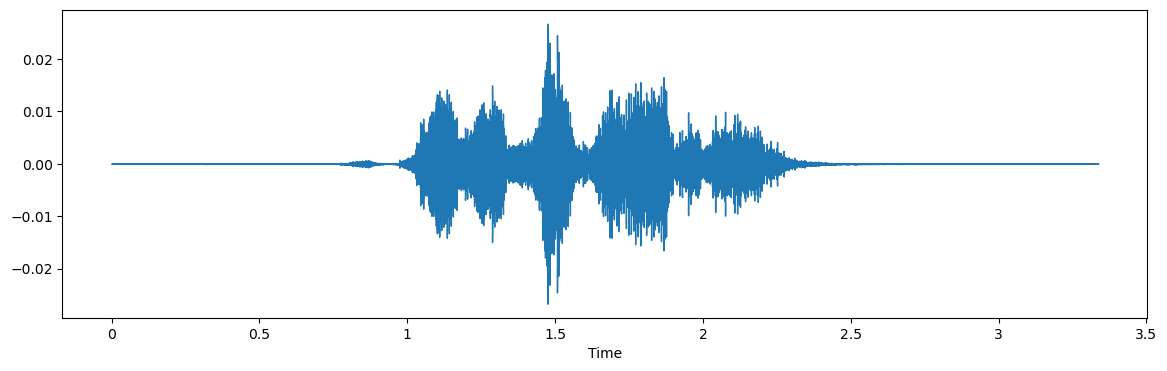

In [53]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

I am employing noise injection, stretching (i.e., changing speed), and pitch modulation as part of the aforementioned augmentation techniques.

## Feature Extraction

In [56]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [57]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [58]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [59]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750032  0.730624  0.735275  0.713529  0.660531   
1  0.305031  0.782180  0.819652  0.804079  0.813433  0.800513  0.691901   
2  0.188256  0.622125  0.699214  0.753343  0.721212  0.701727  0.682356   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.314168  0.759859  0.809052  0.809252  0.778308  0.772055  0.727893   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.674393  0.723761  0.748024  ...  3.282796e-05  3.190220e-05   
2  0.662828  0.686486  0.733960  ...  8.579052e-07  9.576654e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.646329  0.689075  0.725733  ...  6.075756e-05  5.927234e-05   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  3.035647e-05  2.996465e-05  3.246430e-05  3.495524e-05  0.000035  0.000034   
2  7.733596e-07  5.233101e-07  3.592860e-07  9.261693e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640184e-06  0.000011  0.000006   
4  6.027863e-05  6.061316e-05  6.576216e-05  6.102683e-05  0.000063  0.000059   

            161   labels  
0  4.245834e-07  neutral  
1  2.729789e-05  neutral  
2  7.753986e-08  neutral  
3  4.254087e-07  neutral  
4  5.239019e-05  neutral  

[5 rows x 163 columns]

We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [63]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [64]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [65]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [66]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [67]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [69]:
# from tensorflow.keras.optimizers import AdamR
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=76, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.1799 - loss: 1.9973 - val_accuracy: 0.2806 - val_loss: 1.8540 - learning_rate: 0.0010
Epoch 2/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.2204 - loss: 1.9177 - val_accuracy: 0.3046 - val_loss: 1.8106 - learning_rate: 0.0010
Epoch 3/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.2492 - loss: 1.8722 - val_accuracy: 0.3444 - val_loss: 1.7267 - learning_rate: 0.0010
Epoch 4/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.2776 - loss: 1.8122 - val_accuracy: 0.3759 - val_loss: 1.6695 - learning_rate: 0.0010
Epoch 5/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.3100 - loss: 1.7801 - val_accuracy: 0.4019 - val_loss: 1.6325 - learning_rate: 0.0010
Epoch 6/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.3116 - loss: 1.7385 - val_accuracy: 0.3759 - val_loss: 1.6262 - learning_rate: 0.0010
Epoch 7/76
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.3376 - loss: 1.6966 

In [71]:
print("Accuracy of our model on test data : " , model.evaluate(x_train,y_train)*100 , "%")

# epochs = [i for i in range(100)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# test_acc = history.history['val_accuracy']
# test_loss = history.history['val_loss']

# fig.set_size_inches(20,6)
# ax[0].plot(epochs , train_loss , label = 'Training Loss')
# ax[0].plot(epochs , test_loss , label = 'Testing Loss')
# ax[0].set_title('Training & Testing Loss')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")

# ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
# ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
# ax[1].set_title('Training & Testing Accuracy')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9995 - loss: 0.0185
Accuracy of our model on test data :  [0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.999382734298706, 0.017806250602006912, 0.

In [72]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test).reshape(-1, 1)
y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [73]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1            angry         angry
2             fear          fear
3             calm          calm
4            angry         angry
5         surprise      surprise
6             fear          fear
7            angry         happy
8             fear          fear
9              sad           sad

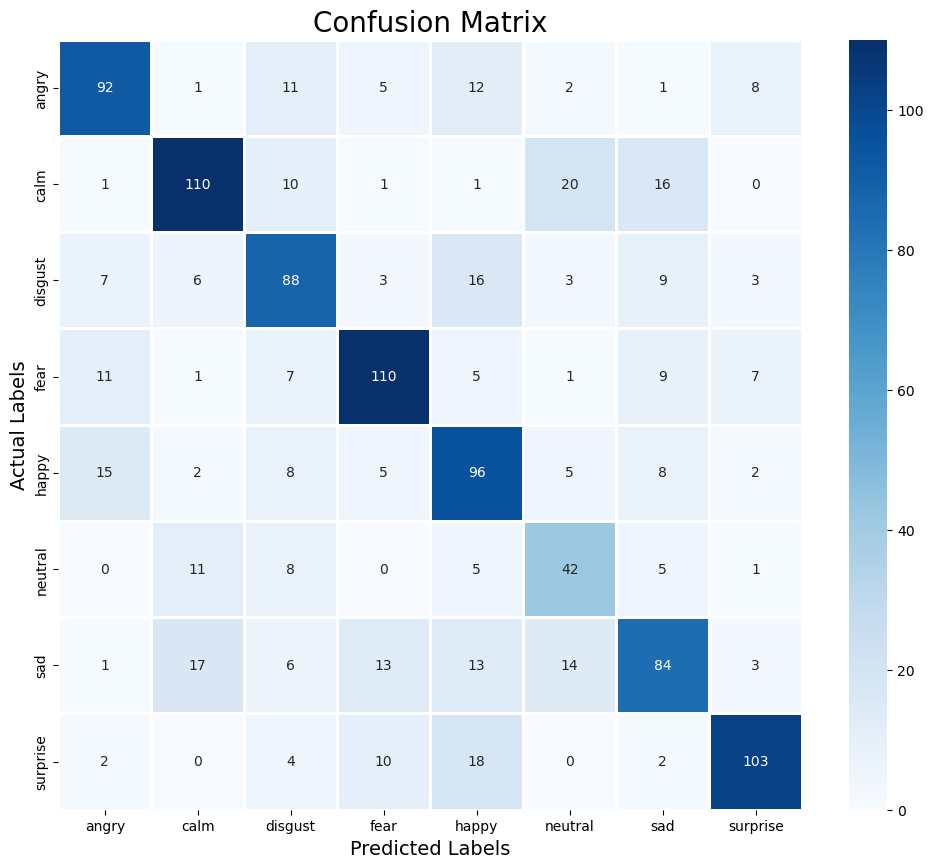

In [74]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.71      0.70      0.70       132
        calm       0.74      0.69      0.72       159
     disgust       0.62      0.65      0.64       135
        fear       0.75      0.73      0.74       151
       happy       0.58      0.68      0.63       141
     neutral       0.48      0.58      0.53        72
         sad       0.63      0.56      0.59       151
    surprise       0.81      0.74      0.77       139

    accuracy                           0.67      1080
   macro avg       0.67      0.67      0.66      1080
weighted avg       0.68      0.67      0.67      1080



In [76]:
total_instances = np.sum(cm.to_numpy())
correct_predictions = np.trace(cm)

accuracy = correct_predictions / total_instances
print(f'Overall Accuracy: {accuracy:.2%}')

Overall Accuracy: 67.13%


We can see our model is more accurate in predicting surprise, angry, calm and fear emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed, noise.



Overall, we achieved 68.70% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

In [135]:
# Save the model to an .h5 file
model.save('my_model.h5')


In [80]:
print(model.input_shape)


(None, 162, 1)


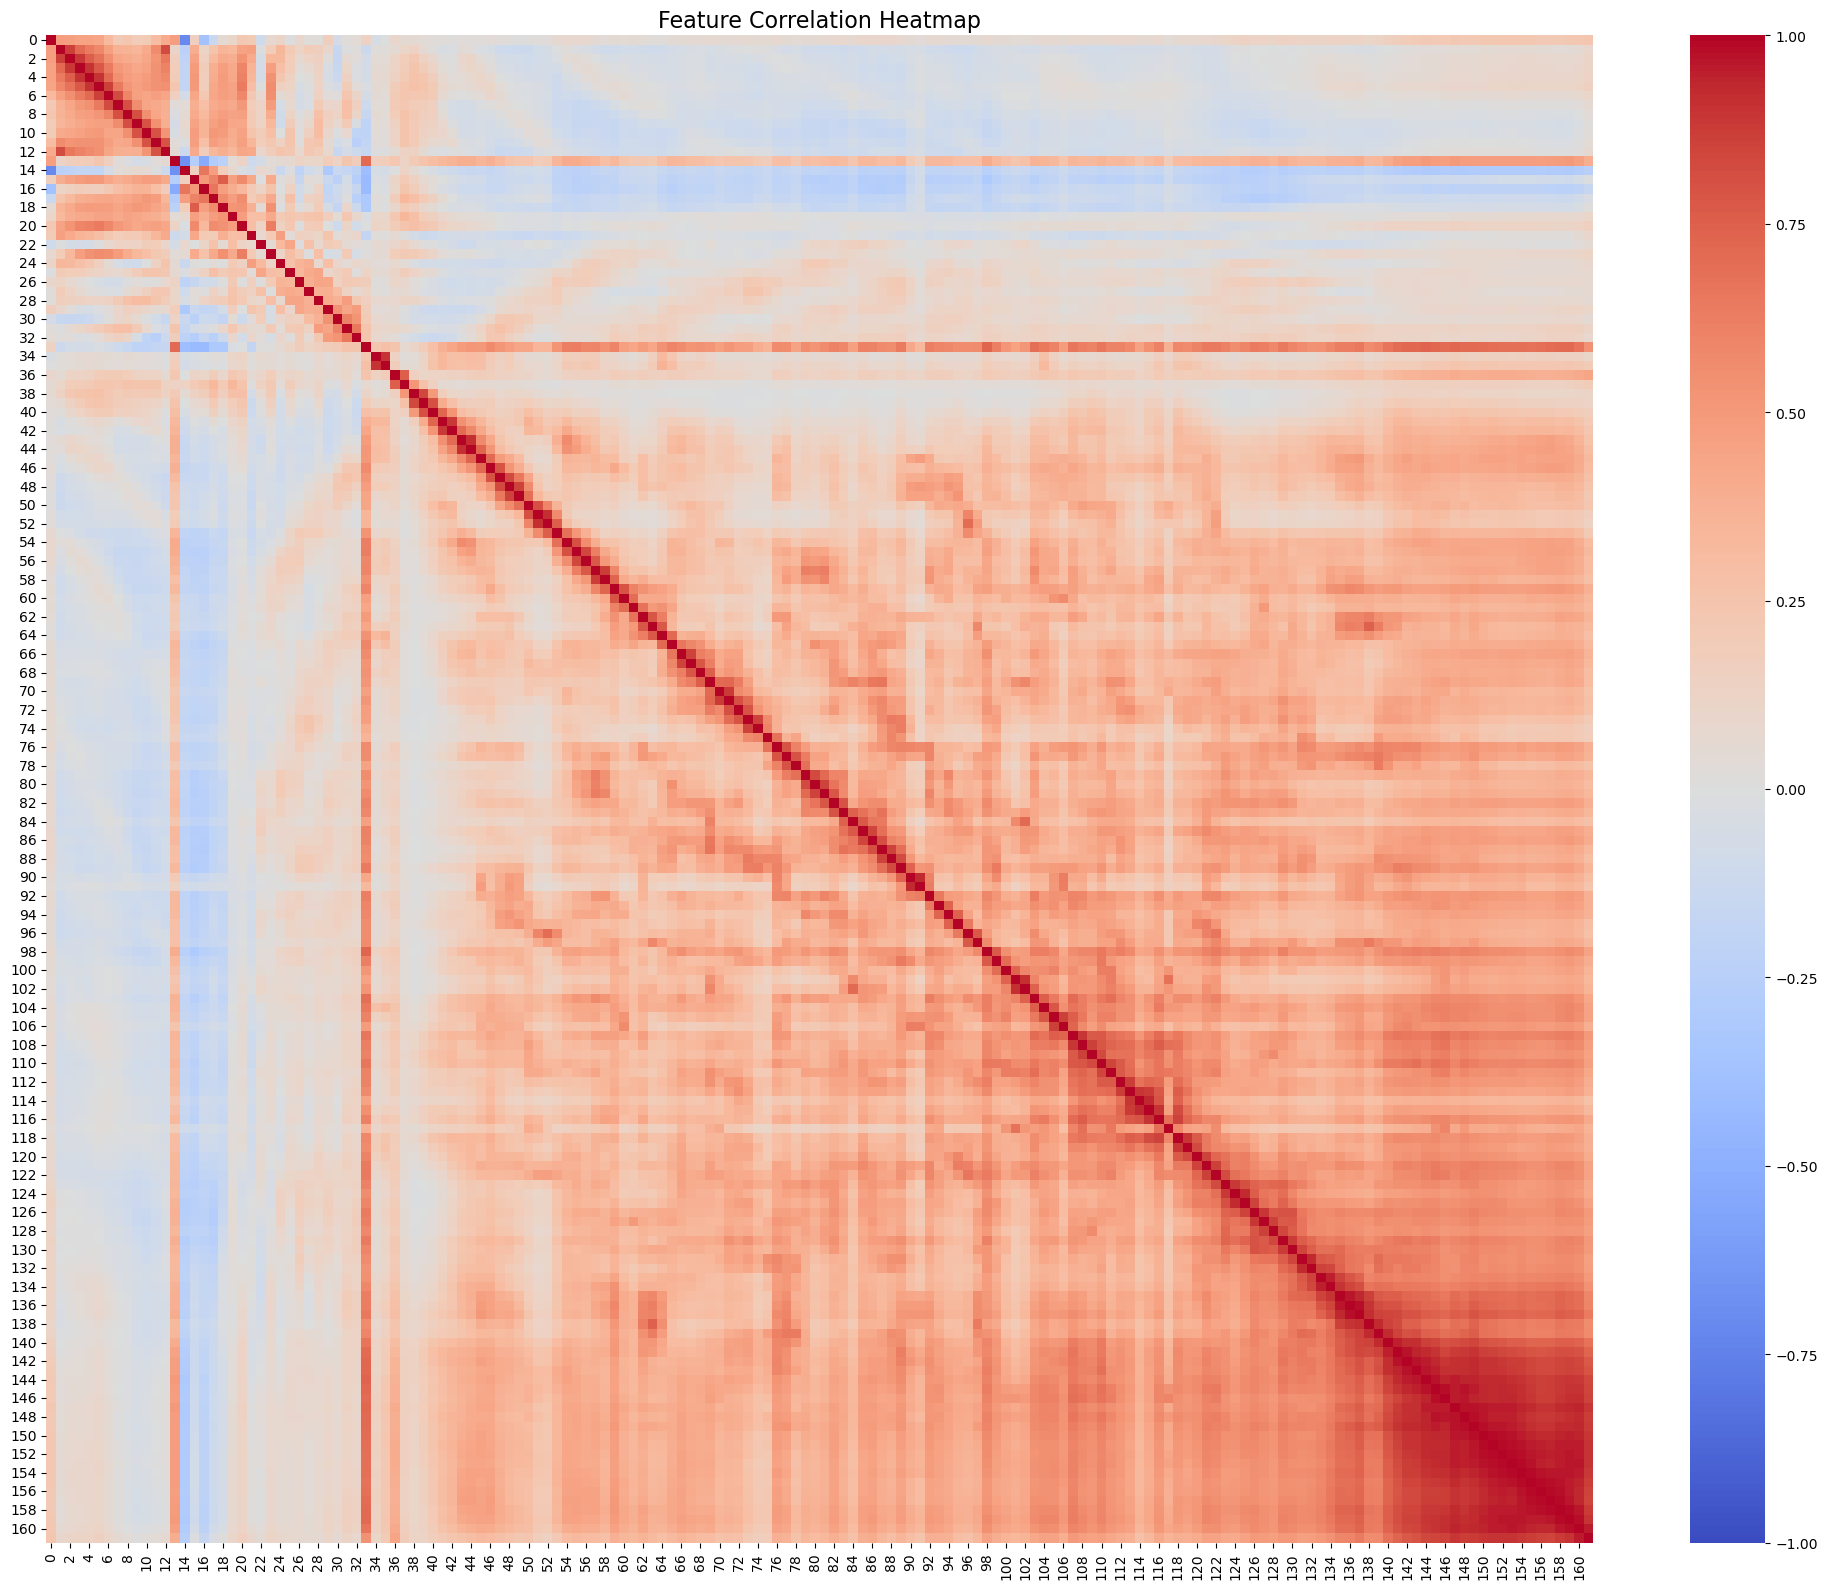

In [81]:
# Select all columns except 'labels'
feature_columns = Features.drop('labels', axis=1)

# Calculate the correlation matrix
correlation_matrix = feature_columns.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

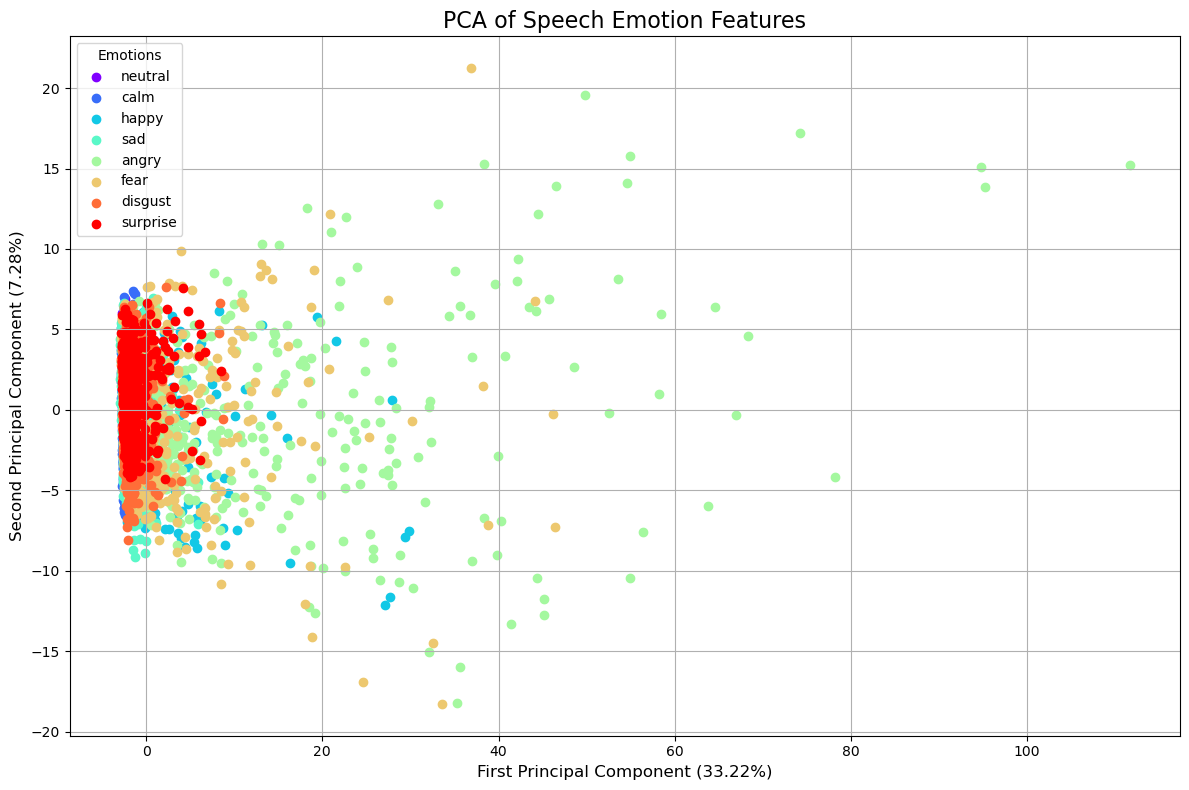

Cumulative explained variance ratio: 40.51%


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'Features' is your DataFrame with the extracted audio features
# and the last column is 'labels'

# Separate features and labels
X = Features.drop('labels', axis=1)
y = Features['labels']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['emotion'] = y

# Create the PCA plot
plt.figure(figsize=(12, 8))
emotions = pca_df['emotion'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(emotions)))

for emotion, color in zip(emotions, colors):
    indices = pca_df['emotion'] == emotion
    plt.scatter(pca_df.loc[indices, 'PC1'], 
                pca_df.loc[indices, 'PC2'], 
                c=[color], 
                label=emotion)

plt.title('PCA of Speech Emotion Features', fontsize=16)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.legend(title='Emotions')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the cumulative explained variance ratio
print(f"Cumulative explained variance ratio: {sum(pca.explained_variance_ratio_):.2%}")

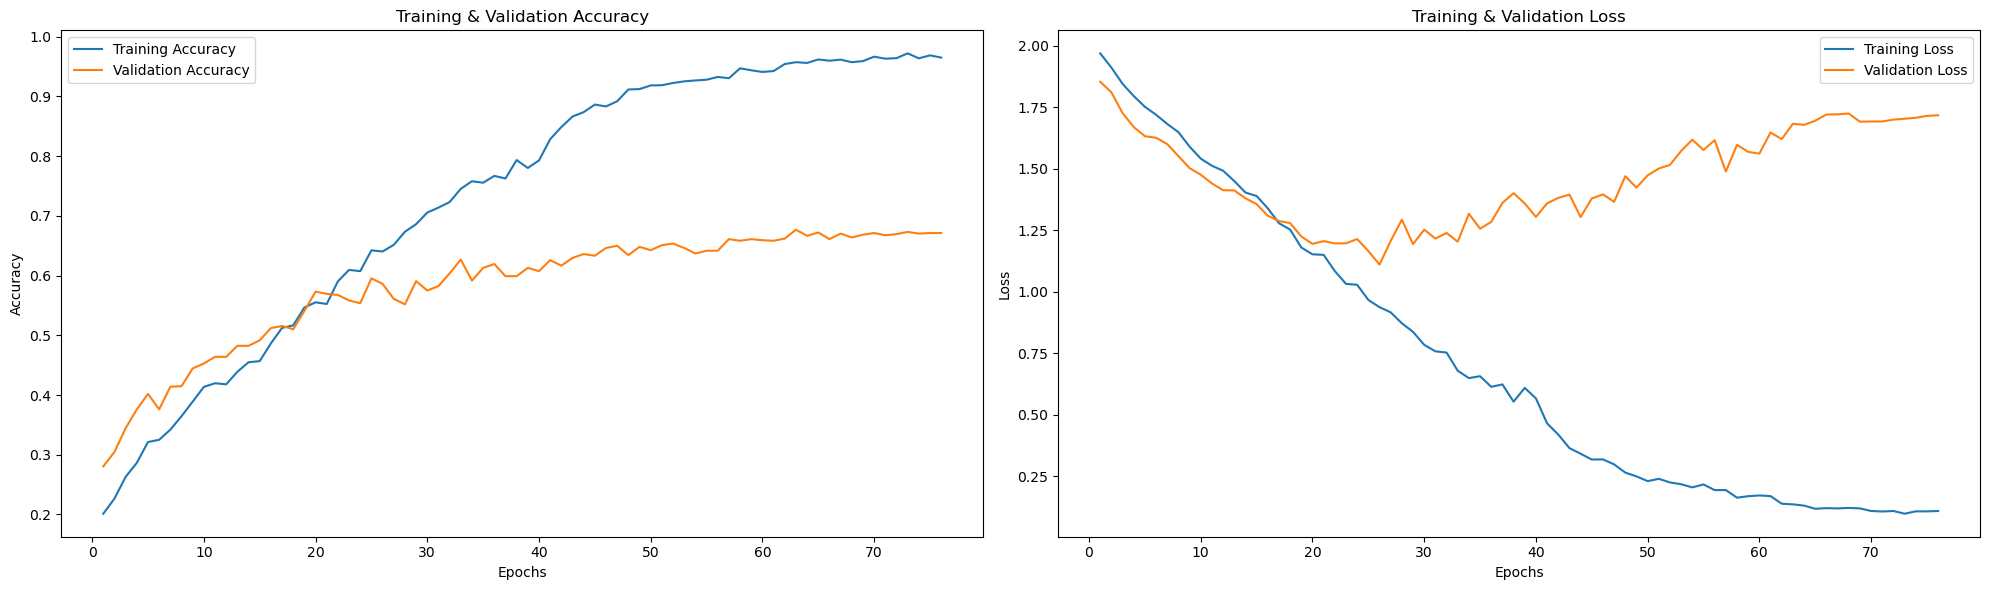

Final Training Accuracy: 0.9651
Final Validation Accuracy: 0.6713
Final Training Loss: 0.1087
Final Validation Loss: 1.7176


In [83]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Extract training and validation metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training and validation accuracy
ax1.plot(epochs, train_acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training & Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss
ax2.plot(epochs, train_loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training & Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print final training and validation metrics
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

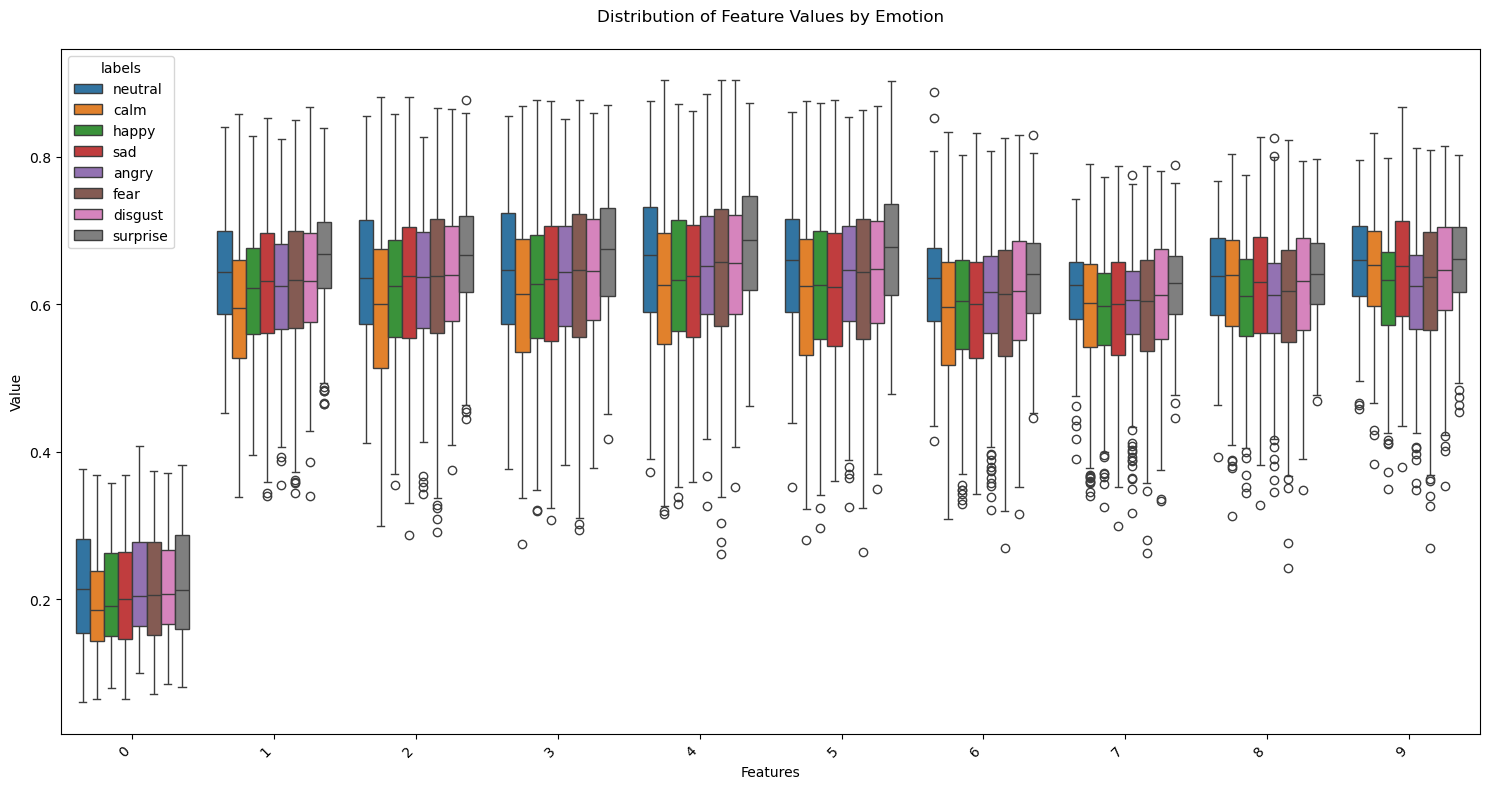

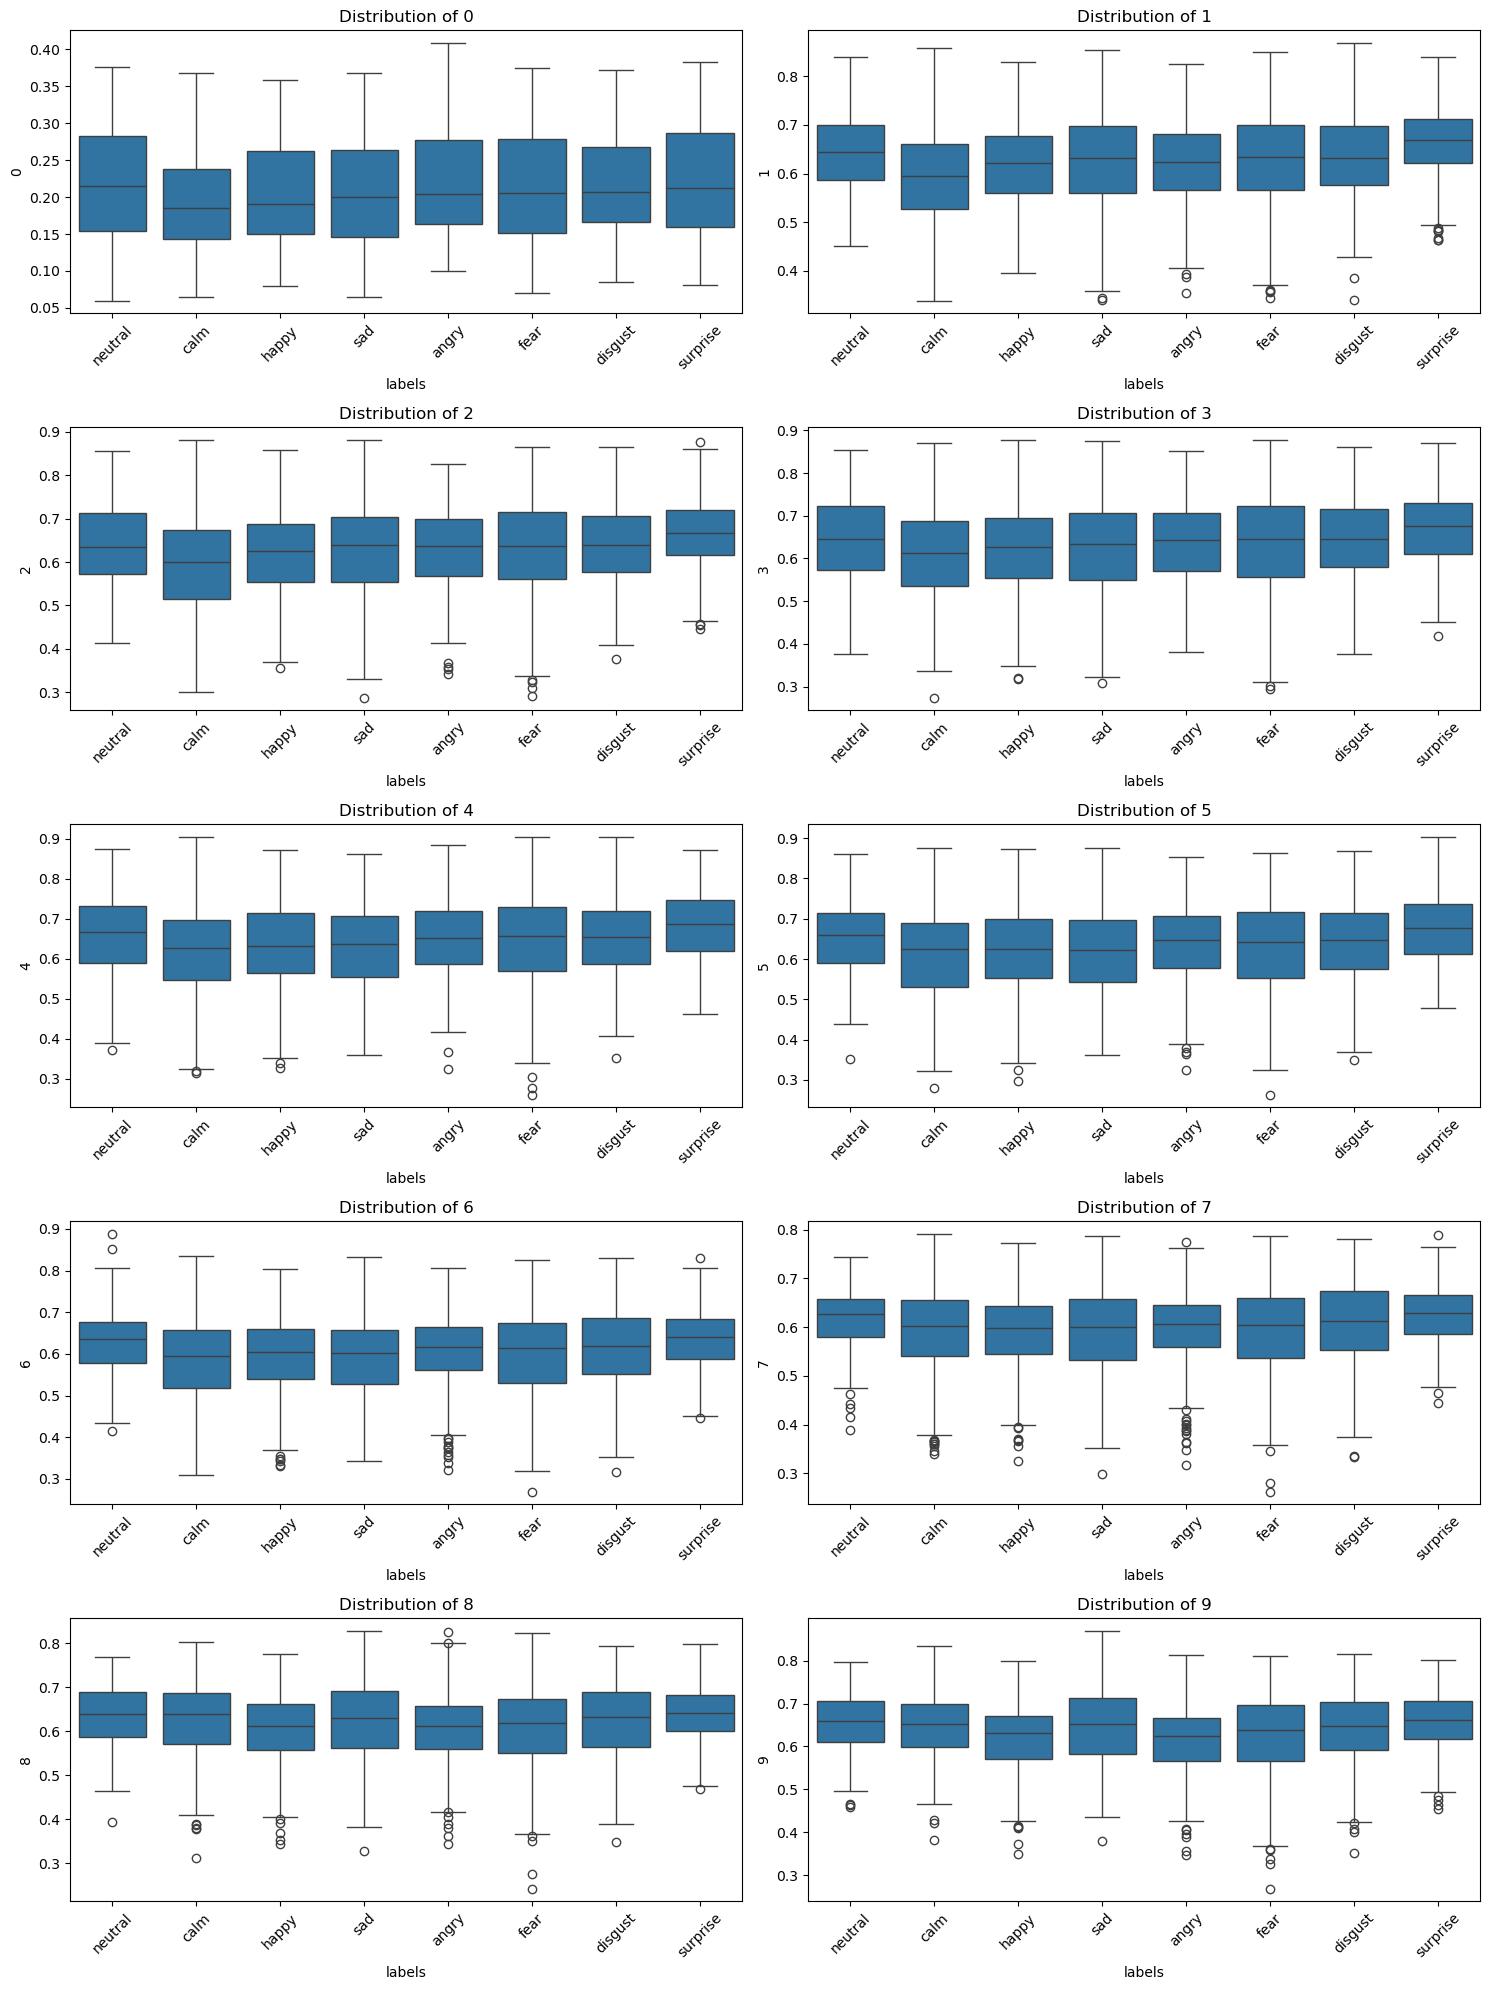

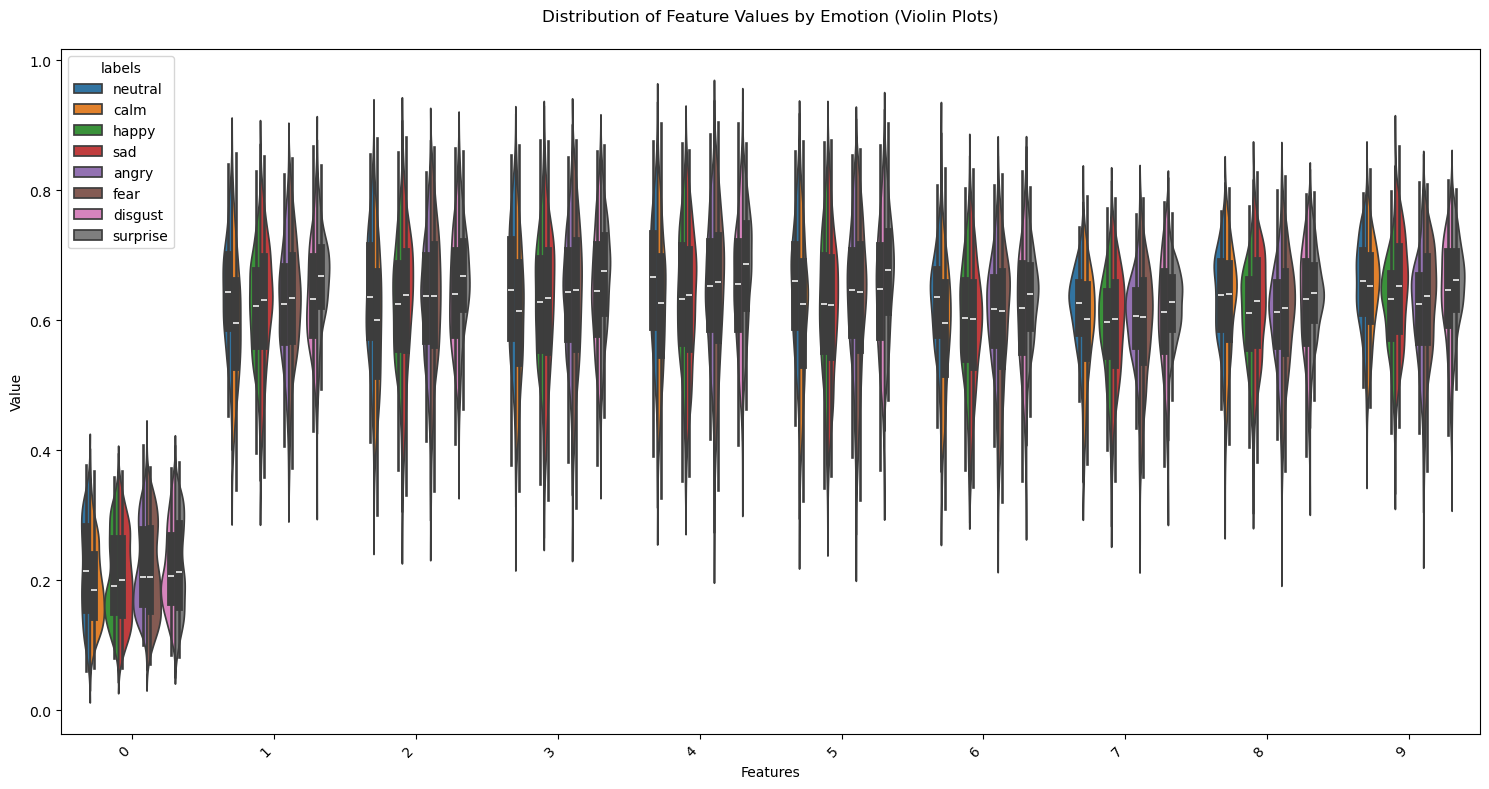


Summary statistics for 0:
          count      mean       std       min       25%       50%       75%  \
labels                                                                        
angry     576.0  0.218765  0.066822  0.099447  0.163291  0.204216  0.277703   
calm      576.0  0.192333  0.061957  0.064359  0.143405  0.185050  0.237871   
disgust   576.0  0.217948  0.064317  0.085381  0.166521  0.206731  0.267144   
fear      576.0  0.214253  0.072893  0.070826  0.151721  0.205117  0.277924   
happy     576.0  0.205627  0.067366  0.079974  0.150315  0.190238  0.262377   
neutral   288.0  0.216343  0.075056  0.060041  0.153876  0.214423  0.282013   
sad       576.0  0.204253  0.069474  0.064793  0.146605  0.200473  0.263743   
surprise  576.0  0.222576  0.072181  0.081120  0.159142  0.212527  0.286728   

               max  
labels              
angry     0.408185  
calm      0.368042  
disgust   0.371831  
fear      0.374064  
happy     0.357883  
neutral   0.376628  
sad       0.36

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_feature_boxplots(Features, n_features=10):
    """
    Create box plots for features grouped by emotion labels
    
    Parameters:
    Features: DataFrame containing features and labels
    n_features: Number of features to plot (default=10)
    """
    
    # Melt the dataframe to get it into the right format for seaborn
    # Exclude the 'labels' column from features
    feature_cols = Features.drop('labels', axis=1).columns
    melted_df = pd.melt(Features, 
                        id_vars=['labels'], 
                        value_vars=feature_cols,
                        var_name='Feature', 
                        value_name='Value')
    
    # Create box plots for the first n_features
    plt.figure(figsize=(15, 8))
    
    # Create a box plot
    sns.boxplot(x='Feature', 
                y='Value', 
                hue='labels', 
                data=melted_df[melted_df['Feature'].isin(feature_cols[:n_features])],
                whis=1.5)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add labels and title
    plt.title('Distribution of Feature Values by Emotion', pad=20)
    plt.xlabel('Features')
    plt.ylabel('Value')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# Create separate box plots for each feature
def create_individual_boxplots(Features, n_features=10):
    """
    Create individual box plots for each feature
    
    Parameters:
    Features: DataFrame containing features and labels
    n_features: Number of features to plot (default=10)
    """
    
    # Calculate number of rows and columns for subplots
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.ravel()  # Flatten axes array
    
    # Get feature columns (excluding 'labels')
    feature_cols = Features.drop('labels', axis=1).columns
    
    # Create box plots
    for i in range(min(n_features, len(feature_cols))):
        sns.boxplot(x='labels', 
                   y=feature_cols[i], 
                   data=Features, 
                   ax=axes[i])
        
        axes[i].set_title(f'Distribution of {feature_cols[i]}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    
    # Remove empty subplots if any
    for i in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Function to create violin plots (alternative to box plots)
def create_violin_plots(Features, n_features=10):
    """
    Create violin plots for features grouped by emotion labels
    
    Parameters:
    Features: DataFrame containing features and labels
    n_features: Number of features to plot (default=10)
    """
    
    # Melt the dataframe
    feature_cols = Features.drop('labels', axis=1).columns
    melted_df = pd.melt(Features, 
                        id_vars=['labels'], 
                        value_vars=feature_cols[:n_features],
                        var_name='Feature', 
                        value_name='Value')
    
    # Create violin plot
    plt.figure(figsize=(15, 8))
    sns.violinplot(x='Feature', 
                   y='Value', 
                   hue='labels', 
                   data=melted_df,
                   split=True)
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Feature Values by Emotion (Violin Plots)', pad=20)
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

# Usage example:
# Create combined box plots for first 10 features
create_feature_boxplots(Features, n_features=10)

# Create individual box plots for first 10 features
create_individual_boxplots(Features, n_features=10)

# Create violin plots for first 10 features
create_violin_plots(Features, n_features=10)

# Calculate and print summary statistics
def print_feature_stats(Features):
    """
    Print summary statistics for each feature grouped by emotion
    """
    feature_cols = Features.drop('labels', axis=1).columns
    
    for feature in feature_cols[:10]:  # First 10 features
        print(f"\nSummary statistics for {feature}:")
        print(Features.groupby('labels')[feature].describe())
        print("-" * 80)

print_feature_stats(Features)